In [20]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk

In [10]:
# %%
cli = MongoClient("localhost",27017)
db = cli.yelp
cursor = db.user.find({}, {"review_count" : 1, "user_id" : 1}).limit(100).sort("review_count", -1)
# %%
yelp_users_by_rating = pd.DataFrame(list(cursor))
n, bins, patches = plt.hist(yelp_users_by_rating['review_count'], 50, normed=0, facecolor='green', alpha=0.75)
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
plt.title('Number of reviews for most active users')

Just as we suspected, most users review far less than 1000 places.
This is without even filtering out restaraunts, so what can be done to stimulate activity on yelp?

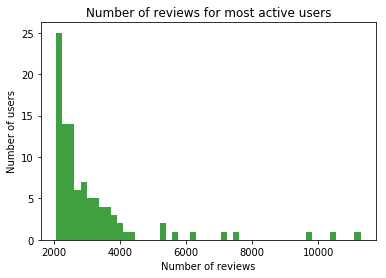

In [11]:
#Note: Save this to a png!
plt.show()

Analyzing behaviour of frequent raters.
Sentiment of their ratings? Do they mostly rate when bad or good, or both?
First query reviews of top 100 frequent raters.

In [12]:
#%%
top_user_ids = yelp_users_by_rating[1:101]['user_id'].values.tolist()
top_user_ids
review_collection = db.get_collection('review')
review_collection.count()
relevent_reviews = review_collection.find({"user_id" :  {"$in" : top_user_ids } })
relevent_reviews_df = pd.DataFrame(list(relevent_reviews))

In [13]:
#%%
def calculate_average_sentiment(string):
    blob = TextBlob(string)
    init = 0
    for sentence in blob.sentences:
        init += sentence.sentiment.polarity
    return (init)/len(blob.sentences)

Looks like most of the top reviewers mostly when they have positive things to say about the business. About one quarter of the relevant reviews have positive sentiment detected in the content of the review. While less than 1% of the relevant reviews have negative sentiment detected in the review.

In [14]:
relevent_reviews_df['sentiment'] = relevent_reviews_df['text'].map(calculate_average_sentiment)

countHigh = len(relevent_reviews_df[relevent_reviews_df['sentiment'] > 0.25])
countLow = len(relevent_reviews_df[relevent_reviews_df['sentiment'] < -0.25])

print("Number of reviews with high sentiment score: %d" %(countHigh))
print("Number of reviews with low sentiment score: %d" %(countLow))

print("Percent of relevant reviews with high sentiment scores: %.2f" %(countHigh/(len(relevent_reviews_df))*100))
print("Percent of relevant reviews with low sentiment scores: %.2f" %(countLow/(len(relevent_reviews_df))*100))

Number of reviews with high sentiment score: 3400
Number of reviews with low sentiment score: 40
Percent of relevant reviews with high sentiment scores: 25.42
Percent of relevant reviews with low sentiment scores: 0.30


Lets see if the review distribution of these users matches the polarity distribution we just calculated.

In [39]:
starsHigh = len(relevent_reviews_df[relevent_reviews_df['stars'] > 4.0])
starsLow = len(relevent_reviews_df[relevent_reviews_df['stars'] < 2.0])

print("Number of reviews with more than 4 stars: %d" %(starsHigh))
print("Number of reviews with less than 2 stars: %d" %(starsLow))

print("Percent of relevant reviews with high star ratings: %.2f" %(starsHigh/len(relevent_reviews_df)*100))
print("Percent of relevant reviews with low star ratings: %.2f" %(starsLow/len(relevent_reviews_df)*100))

Number of reviews with more than 4 stars: 1684
Number of reviews with less than 2 stars: 281
Percent of relevant reviews with high star ratings: 12.59
Percent of relevant reviews with low star ratings: 2.10


This is somewhat similar but not as close as we would like to have seen.

In [42]:
normalizedSentiment = []
normalizedStars = []

for sentimentVal in relevent_reviews_df['sentiment']:
    normVal = (sentimentVal + 1)/2
    normalizedSentiment.append(normVal)
    
for starVal in relevent_reviews_df['stars']:
    normVal = (starVal-1)/4
    normalizedStars.append(normVal)
    
xvals = np.linspace(0, 1, 13377)

To visualize this comparison between stars and sentiment, it would be easier to show this on a line plot. First, both values will need to be normalized between 0 and 1 to be on the same scale. This is done by creating two new arrays for normalized values

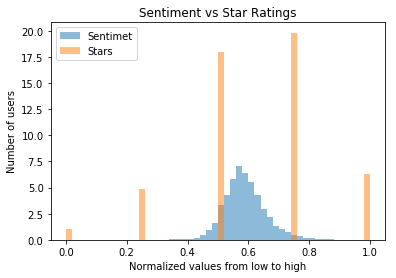

In [43]:
plt.hist(normalizedSentiment, bins, normed=1, alpha=0.5, label='Sentimet')
plt.hist(normalizedStars, bins, normed=1, alpha=0.5, label='Stars')
plt.legend(loc='upper left')
plt.xlabel('Normalized values from low to high')
plt.ylabel('Number of users')
plt.title('Sentiment vs Star Ratings')
plt.show()

This plot doesn't show us as much as we would like. Each bar of the stars data represents the number of reviews with a rating of 1, 2, 3, 4, or 5 stars. These bars are much higher because there are only 5 bins they can fall into. The sentiment data is grouped much closer together and follows a nice bell curve. Most of the sentiment valuses fall slightly higher than 0.5 which means people are giving reviews using language that is determined to be either neutral or positive. There are some similarities that can be seen between these two but more analysis is needed to fine better data.